In [1]:
from importlib import reload
from torch.nn import functional as F
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

#import graph
from graph_based.models.gnn.layers import GraphConvolution
from graph_based.utils.loader import  get_dataset
from graph_based.utils.evaluate import eval_normal, eval_hybrid
# from graph_based.models.GAT import SpGAT
from graph_based.train import train_hybrid
from graph_based.models.gnn.layers import GraphConvolution
from graph_based.models import resnet
# from graph_based.models import GAT
from graph_based.models.hyper_models import HybridGNN



In [2]:
reload(resnet)

<module 'graph_based.models.resnet' from 'd:\\AI Project\\Icaller\\graph_based\\models\\resnet.py'>

In [3]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

## import data

In [4]:
features = pd.read_csv("./graph_based/dataset/node_2label_balance.csv").to_numpy()
links = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv").to_numpy().astype(float)
links_df = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv")
train_xgb = pd.read_csv("./graph_based/dataset/train.csv").to_numpy()

## get data train, test

In [5]:
X_gnn_pool, X_gnn_test, X_xgb_pool, X_xgb_test, y_pool, y_test = train_test_split(features, train_xgb, features[:,-1],test_size=0.2, random_state= 42)

In [6]:
X_gnn_train, X_gnn_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, y_unlabel = train_test_split(X_gnn_pool, X_xgb_pool, y_pool, test_size=0.5, random_state= 42)


In [7]:
print(X_gnn_train.shape, X_gnn_unlabeled.shape, X_gnn_test.shape)

(10665, 10) (10666, 10) (5333, 10)


In [13]:
links[:,0]

array([1.07700000e+03, 1.07700000e+03, 1.07700000e+03, ...,
       9.19998039e+11, 9.23336454e+11, 9.98775630e+07])

In [12]:
X_gnn_train[:,0]

array([8.43641252e+10, 8.49190430e+10, 8.49816775e+10, ...,
       8.49634178e+10, 8.49662749e+10, 8.48661055e+10])

In [9]:
link_train = links[links[:,0].isin(X_gnn_train[:,0])][links[:,1].isin(X_gnn_train[:0])]

AttributeError: 'numpy.ndarray' object has no attribute 'isin'

In [14]:
np.isin(links[:,0],X_gnn_train[:,0])

array([False, False, False, ..., False, False,  True])

In [10]:
dataset_train, nrm_adj_train, adjs_train = get_dataset(X_train, links_df, X_train.shape[0]) 

d:\AI Project\Icaller\graph_based\utils\loader.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(features[:,0])][links_df['phone_in'].isin(features[:,0])]


In [16]:
links[np.where(np.isin(links[:,0],X_gnn_train[:,0]))]

array([[1.31026679e+10, 8.42456787e+11, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.31026679e+10, 8.42499988e+11, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.91240950e+10, 8.43426447e+10, 5.00000000e+00, ...,
        7.00000000e+00, 2.00000000e+00, 8.37001435e+02],
       ...,
       [9.02706195e+08, 8.42856787e+11, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [9.02706195e+08, 8.49058084e+10, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.98775630e+07, 8.49026896e+10, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [28]:
tmp = np.array([[5, 2, 0, 3],
       [4, 5, 0, 6],
       [8, 4, 8, 7],
       [7, 7, 6, 1]])
tmp

array([[5, 2, 0, 3],
       [4, 5, 0, 6],
       [8, 4, 8, 7],
       [7, 7, 6, 1]])

In [34]:
tmp1 = tmp[np.where(np.isin(tmp[:,0],[7,4]))]
print(tmp1)
tmp1[np.where(np.isin(tmp1[:,1],[7,4]))]

[[4 5 0 6]
 [7 7 6 1]]


array([[7, 7, 6, 1]])

## model resnet

In [11]:
reload(resnet)

<module 'graph_based.models.resnet' from 'd:\\AI Project\\Icaller\\graph_based\\models\\resnet.py'>

In [12]:
nets = [resnet.ResNet(GraphConvolution,
             in_features=features.shape[1] - 2,
             cfg=[16, 16, 32, 16],
             n_residual_units=[2, 2, 2],
             hidden_layers_fc= [16,8],
             num_classes=None) for _ in range(features.shape[1] - 2)]

In [13]:
model = HybridGNN(2, 'cuda', *nets).cuda()

c:\Users\GroooDev\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
cummulative = []

In [15]:
dataset_test, nrm_adj_test, adjs_test = get_dataset(X_test, links_df, X_test.shape[0]) 

d:\AI Project\Icaller\graph_based\utils\loader.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(features[:,0])][links_df['phone_in'].isin(features[:,0])]


In [31]:
model, loss = train_hybrid(model, dataset_train, adjs_train, 'adamw', 'weighted_nll', 'cuda', 5e-5, 500)
cummulative.extend(loss)

100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


In [40]:
# model.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
pred, f1_gnn, acc_gnn, prob = eval_hybrid(model, dataset_test.data, dataset_test.targets, adjs_test)
pred, f1_resnet_train, acc_resnet_train, prob = eval_hybrid(model, dataset_train.data, dataset_train.targets, adjs_train)

In [41]:
print(f1_gnn,acc_gnn, len(prob))
print(f1_resnet_train,acc_resnet_train, len(prob))

0.8136376769719734 0.7581098818676167 10665
0.8230075833452568 0.7680262541022035 10665


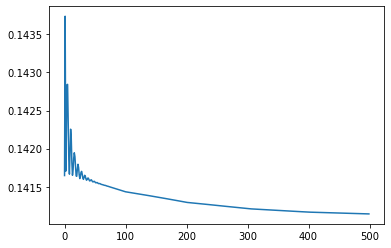

In [34]:
plt.plot(loss)

In [35]:
loss[-1]

0.14114336669445038

In [37]:
# torch.save(model.state_dict(), "mode_new.pt")

In [38]:
XGB1 = xgb.XGBClassifier(eval_metric = "logloss",objective = "binary:logistic", booster = "gbtree", tree_method = "gpu_hist",
                             max_depth = 4, gamma = 2, learning_rate = 0.005, n_estimators = 300, subsample = 0.7 , colsample_bytree = 0.7, min_child_weight = 4, use_label_encoder  = False )
evalset1 = [(X_xgb_train[:,1:-1], y_train), (X_xgb_test[:,1:-1], y_test)]
XGB1 = XGB1.fit(X_xgb_train[:,1:-1], y_train , eval_metric='logloss', eval_set=evalset1)

[0]	validation_0-logloss:0.69004	validation_1-logloss:0.69002
[1]	validation_0-logloss:0.68693	validation_1-logloss:0.68686
[2]	validation_0-logloss:0.68381	validation_1-logloss:0.68371
[3]	validation_0-logloss:0.68081	validation_1-logloss:0.68068
[4]	validation_0-logloss:0.67797	validation_1-logloss:0.67782
[5]	validation_0-logloss:0.67502	validation_1-logloss:0.67483
[6]	validation_0-logloss:0.67202	validation_1-logloss:0.67183
[7]	validation_0-logloss:0.66905	validation_1-logloss:0.66885
[8]	validation_0-logloss:0.66629	validation_1-logloss:0.66606
[9]	validation_0-logloss:0.66346	validation_1-logloss:0.66322
[10]	validation_0-logloss:0.66056	validation_1-logloss:0.66031
[11]	validation_0-logloss:0.65790	validation_1-logloss:0.65761
[12]	validation_0-logloss:0.65512	validation_1-logloss:0.65481
[13]	validation_0-logloss:0.65250	validation_1-logloss:0.65218
[14]	validation_0-logloss:0.64975	validation_1-logloss:0.64942
[15]	validation_0-logloss:0.64733	validation_1-logloss:0.64697
[1

In [42]:
prediction_test1 = XGB1.predict(X_xgb_test[:,1:-1])
f1_xgb = f1_score(y_test,prediction_test1)
acc_xgb = accuracy_score(y_test,prediction_test1)

In [45]:
print(f1_xgb, acc_xgb)
print(f1_gnn,acc_gnn, len(prob))

0.8924274593064402 0.8859928745546597
0.8136376769719734 0.7581098818676167 10665


## Cotrain mvlearn based

In [55]:
estimator = [XGB1, model]
X_train_list = [X_xgb_train, X_train]
X_unlabeled_list = [X_xgb_unlabeled, X_unlabeled ]
X_test_list = [X_xgb_test, dataset_test, adjs_test]

# f1_cotrain, acc_cotrain, f1_test1, acc_test1, f1_test2, acc_test2, f1_train2, acc_train2, cummulative = cotrain(estimator, X_train_list, X_unlabeled_list, X_test_list, y_train, y_test, 10, 10,2000,100, links_df)

In [68]:
def predict_ct(estimator1, estimator2, X_xgb_test, dataset_test, adjs_test):
    # predict each view independently
    y1 = estimator1.predict(X_xgb_test[:,1:-1])
    y2,  _, _, y2_probs = eval_hybrid(estimator2, dataset_test.data, dataset_test.targets, adjs_test)
    # initialize
    y_pred = np.zeros(X_xgb_test.shape[0],)
    
    y1_probs = estimator1.predict_proba(X_xgb_test[:,1:-1])
    y2_probs = y2_probs.cpu().numpy()

    # predict samples based on trained classifiers
    for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
        
        # if classifiers agree, use their prediction
        if y1_i == y2_i:
            y_pred[i] = y1_i
        # if classifiers don't agree, take the more confident
        else:
            sum_y_probs = [prob1 + prob2 for (prob1, prob2) in
                            zip(y1_probs[i], y2_probs[i])]

            y_pred[i] = np.argmax(sum_y_probs)
    return y_pred

def cotrain(estimator1, estimator2, X_train, X_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, p, n, unlabeled_pool_size , k ):
    
    global dataset_test, adjs_test, X_test, X_xgb_test, f1_gnn, acc_gnn, loss
    f1_gnn_test = [f1_gnn]
    acc_gnn_test = [acc_gnn]
    f1_xgb_test = [f1_xgb]
    acc_xgb_test = [acc_xgb]
    loss_gnn = [loss[-1]]
    # set of unlabeled samples
    U = np.array(range(X_unlabeled.shape[0]))

    # shuffle unlabeled_pool data for easy random access
    np.random.shuffle(U)

    # the small pool of unlabled samples to draw from in training
    unlabeled_pool = U[-min(len(U), unlabeled_pool_size):]

    # remove the pool from overall unlabeled data
    U = U[:-len(unlabeled_pool)].tolist()

    # number of rounds of co-training
    counter = 0

    # machine epsilon
    eps = np.finfo(float).eps
    
    y_train1 = y_train.copy()
    y_train2 = y_train.copy()

    while counter < k and U :
        counter+=1 
                
        temp1 = X_xgb_unlabeled[unlabeled_pool]
        
        temp2 = X_unlabeled[unlabeled_pool]
        
        links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]

        dataset, _ , adjs = get_dataset(temp2, links.to_numpy().astype(float), temp2.shape[0])
        
        # predict log probability for greater spread in confidence

        y1_prob = np.log(estimator1.predict_proba(temp1[:,1:-1]) + eps)
        
        _,  _, _, prob = eval_hybrid(estimator2, dataset.data, dataset.targets, adjs)
        y2_prob = np.log(prob.cpu().numpy() + eps)
        
        n_index1, p_index1, n_index2, p_index2= [], [], [], []
        
        # take the most confident labeled examples from the
        # unlabeled pool in each category and put them in L
        for i in (y1_prob[:, 0].argsort())[-n:]:
            if y1_prob[i, 0] > np.log(0.5):
                n_index1.append(i)
        for i in (y1_prob[:, 1].argsort())[-p:]:
            if y1_prob[i, 1] > np.log(0.5):
                p_index1.append(i)
        for i in (y2_prob[:, 0].argsort())[-n:]:
            if y2_prob[i, 0] > np.log(0.5):
                n_index2.append(i)
        for i in (y2_prob[:, 1].argsort())[-p:]:
            if y2_prob[i, 1] > np.log(0.5):
                p_index2.append(i)
        
        # n_index = np.unique(n_index).tolist()
        # p_index = np.unique(p_index).tolist()
        
        # create new labels for new additions to the labeled group
        y_train1 = np.concatenate((y_train1, 
                            [0]*len(n_index2), 
                            [1]*len(p_index2)),
                            axis = 0)
        y_train2 = np.concatenate((y_train2, 
                            [0]*len(n_index1), 
                            [1]*len(p_index1)),
                            axis = 0)
        
        X_xgb_train = np.concatenate((X_xgb_train, 
                                X_xgb_unlabeled[[unlabeled_pool[x] for x in n_index2]],  
                                X_xgb_unlabeled[[unlabeled_pool[x] for x in p_index2]]))
        X_train = np.concatenate((X_train, 
                                X_unlabeled[[unlabeled_pool[x] for x in n_index1]],  
                                X_unlabeled[[unlabeled_pool[x] for x in p_index1]]))
        # remove newly labeled samples from unlabeled_pool
        del_unlabeled_pool = [unlabeled_pool[x] for x in np.unique(n_index1 + p_index1 + n_index2 + p_index2).tolist()]
        unlabeled_pool = np.array(unlabeled_pool)[~np.isin(unlabeled_pool, del_unlabeled_pool)].tolist()
        # add new elements to unlabeled_pool
        add_counter = 0
        num_to_add = len(del_unlabeled_pool) 
        while add_counter != num_to_add and U :
            add_counter += 1
            unlabeled_pool.append(U.pop())           
        print('len(U)',len(U))  

        
        # get new dataset for graph
        links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
        
        dataset, _ , adjs = get_dataset(X_train, links.to_numpy().astype(float), X_train.shape[0])
        
        # fit new data
        estimator1 = estimator1.fit(X_xgb_train[:,1:-1],y_train1)
        estimator2, loss = train_hybrid(estimator2, dataset, adjs, 'adamw', 'multilabel', 'cuda', 5e-4, 200)
        loss_gnn.append(loss[-1])
        
        y_pred_my_ct = predict_ct(estimator1, estimator2, X_xgb_test, dataset_test, adjs_test )
        
        # get value evaluate
        f1_cotrain.append(f1_score(y_test,y_pred_my_ct))
        acc_cotrain.append(accuracy_score(y_test,y_pred_my_ct))

        #Keeping track of accuracy
        
        prediction_test1 =estimator1.predict(X_xgb_test[:,1:-1])
        
        f1_xgb_test.append(f1_score(y_test,prediction_test1))
        acc_xgb_test.append(accuracy_score(y_test,prediction_test1))
        
        _,  acc, f, _ = eval_hybrid(estimator2, dataset_test.data, dataset_test.targets, adjs_test)
        acc_gnn_test.append(acc)
        f1_gnn_test.append(f)
    
        _,  acc, f, _ = eval_hybrid(estimator2, dataset.data, dataset.targets, adjs)
        acc_gnn_train.append(acc)
        f1_gnn_train.append(f)
        print("Interator {0}".format(counter))
        print("==========================================================")

    # predict each view independently
    
    
    return f1_cotrain, acc_cotrain, f1_xgb_test, acc_xgb_test, acc_gnn_train, f1_gnn_train, acc_gnn_test, f1_gnn_test, loss_gnn

In [69]:
f1_cotrain, acc_cotrain, f1_xgb_test, acc_xgb_test, acc_gnn_train, f1_gnn_train, acc_gnn_test, f1_gnn_test, loss_gnn = cotrain(XGB1, model, X_train, X_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, 30, 30, 1000, 50 )

[[8.47054161e+10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [8.48998819e+10 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  4.85665278e+02 1.00000000e+00]
 [8.49695705e+10 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.18707049e+02 1.00000000e+00]
 ...
 [8.43674369e+10 2.00000000e+00 0.00000000e+00 ... 2.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [8.49674371e+10 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.49769167e+10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


<ipython-input-68-b79d855b1176>:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [58]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import matplotlib.patches as mpatches


# indexing = range(len(f1_cotrain))
# # hnd1, = plt.plot(indexing,f1_cotrain,'r',label='f1_cotrain')
# hnd1, = plt.plot(indexing,acc_cotrain,'g',label='acc_cotrain')
# # hnd2, = plt.plot(indexing,f1_xgb_test,'b',label='f1_xgb_test')
# hnd2, = plt.plot(indexing,acc_xgb_test,'c',label='acc_xgb_test')
# hnd2, = plt.plot(indexing,acc_gnn_train,'k',label='acc_gnn_train')
# # hnd2, = plt.plot(indexing,f1_gnn_train,'m',label='f1_gnn_train')
# hnd2, = plt.plot(indexing,acc_gnn_test,'y',label='acc_gnn_test')
# # hnd2, = plt.plot(indexing,f1_gnn_test,'w',label='f1_gnn_test')
# # print(num_n_new,num_p_new)

# plt.legend(loc='best')
# plt.ylabel('Accuracy')
# plt.xlabel('Iteration')
# plt.title('Dropout')
# plt.rcParams["figure.figsize"] = (10,10)
# plt.show()

In [59]:
# plt.plot(loss_gnn)

## CoAL

In [60]:
def coAL(estimator1, estimator2, X_train, X_unlabeled, y_train, p, n, unlabeled_pool_size , k ):
    

    # set of unlabeled samples
    U = np.array(range(X_unlabeled.shape[0]))

    # shuffle unlabeled_pool data for easy random access
    np.random.shuffle(U)

    # the small pool of unlabled samples to draw from in training
    unlabeled_pool = U[-min(len(U), unlabeled_pool_size):]

    # remove the pool from overall unlabeled data
    U = U[:-len(unlabeled_pool)].tolist()

    # number of rounds of co-training
    counter = 0

    # machine epsilon
    eps = np.finfo(float).eps

    while counter < k :
        counter+=1 
                
        temp1 = X_unlabeled[unlabeled_pool]
        
        temp2 = X_unlabeled[unlabeled_pool]

        
        links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]

        dataset, _ , adjs = get_dataset(temp2, links.to_numpy().astype(float), temp2.shape[0])
        
        # predict log probability for greater spread in confidence

        y1_prob = estimator1.predict_proba(temp1[:,1:-1])
        b1 = abs(y1_prob[:, 0] - y1_prob[:, 1])
        y1_prob = np.log(y1_prob + eps)
        
        _,  _, _, prob = eval_hybrid(estimator2, dataset.data, dataset.targets, adjs)
        y2_prob = prob.cpu()
        b2 = abs(y2_prob[:, 0] - y2_prob[:, 1])
        y2_prob = np.log(y2_prob + eps).numpy()
        
        b_index = []
        
        for i in range(len(b1)):
            if b1[i] < 0.5:
                b_index.append(i)
        for i in range(len(b2)):
            if b2[i] < 0.5:
                b_index.append(i)
        
        b_index = np.unique(b_index).tolist()
        
        X_train = np.concatenate((X_train, 
                                X_unlabel[[unlabeled_pool[x] for x in b_index]]))
        y_train = np.concatenate((y_train, 
                            X_unlabel[[unlabeled_pool[x] for x in b_index]][:,-1]),
                            axis = 0)
        
        n_index, p_index = [], []
        # take the most confident labeled examples from the
        # unlabeled pool in each category and put them in L
        for i in (y1_prob[:, 0].argsort())[-n:]:
            if y1_prob[i, 0] > np.log(0.7):
                n_index.append(i)
        for i in (y1_prob[:, 1].argsort())[-p:]:
            if y1_prob[i, 1] > np.log(0.7):
                p_index.append(i)
        for i in (y2_prob[:, 0].argsort())[-n:]:
            if y2_prob[i, 0] > np.log(0.7):
                n_index.append(i)
        for i in (y2_prob[:, 1].argsort())[-p:]:
            if y2_prob[i, 1] > np.log(0.7):
                p_index.append(i)
        
        n_index = np.unique(n_index).tolist()
        p_index = np.unique(p_index).tolist()
        # create new labels for new additions to the labeled group
        y_train = np.concatenate((y_train, 
                            [0]*len(n_index), 
                            [1]*len(p_index)),
                            axis = 0)
        
        X_train = np.concatenate((X_train, 
                                X_unlabel[[unlabeled_pool[x] for x in n_index]],  
                                X_unlabel[[unlabeled_pool[x] for x in p_index]]))
        # remove newly labeled samples from unlabeled_pool
        del_unlabeled_pool = [unlabeled_pool[x] for x in np.unique(n_index+p_index+b_index).tolist()]
        unlabeled_pool = np.array(unlabeled_pool)[~np.isin(unlabeled_pool, del_unlabeled_pool)].tolist()
        # add new elements to unlabeled_pool
        add_counter = 0
        num_to_add = len(np.unique(n_index+p_index+b_index).tolist())
        while add_counter != num_to_add and U :
            add_counter += 1
            unlabeled_pool.append(U.pop())           
                        
        
        

        estimator1.fit(X_train[:,1:-1],y_train)
        
        links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
        
        dataset, _ , adjs = get_dataset(X_train, links.to_numpy().astype(float), X_train.shape[0])
        
        estimator2, loss = train_hybrid(estimator2, dataset, adjs, 'adamw', 'multilabel', 'cuda', 1e-3, 100)

        
        #Keeping track of accuracy
        
        prediction_test1 =estimator1.predict(X_test[:,1:-1])
        
        f1.append(f1_score(y_test,prediction_test1))
        acc1.append(accuracy_score(y_test,prediction_test1))
        
        _,  acc, f, _ = eval_hybrid(estimator2, dataset_test.data, dataset_test.targets, adjs_test)
        acc2.append(acc)
        f2.append(f)
    
        _,  acc, _, _ = eval_hybrid(estimator2, dataset.data, dataset.targets, adjs)
        acc3.append(acc)
        

        print("Interator {0}".format(counter+1))
        print("==========================================================")
        counter+=1
    print("lenU", len(U))
    return acc1, f1, acc2, f2, acc3,  X_train, y_train

In [61]:
acc1, f1, acc2, f2, acc3,  _, _ = coAL(XGB1, model, X_train, X_unlabel, y_train, 10, 10, 1000 , 100 )

NameError: name 'X_unlabel' is not defined

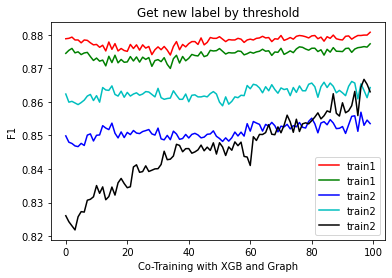

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

indexing = range(len(acc1)-1)
hnd1, = plt.plot(indexing,acc1[1:],'r',label='train1')
hnd1, = plt.plot(indexing,f1[1:],'g',label='train1')
hnd2, = plt.plot(indexing,acc2[1:],'b',label='train2')
hnd2, = plt.plot(indexing,f2[1:],'c',label='train2')
hnd2, = plt.plot(indexing,acc3[1:],'k',label='train2')
hnd2, = plt.plot(indexing,acc3[1:],'m',label='train2')
# print(num_n_new,num_p_new)
plt.legend(loc='best')
plt.ylabel('F1')
plt.xlabel('Co-Training with XGB and Graph')
plt.title('Get new label by threshold')
plt.show()

## Co2AL

In [ ]:
def co2al(estimator1, estimator2, X_train, X_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, p, n, unlabeled_pool_size , k ):
    
    global dataset_test, adjs_test, X_test, X_xgb_test, f1_resnet, acc_resnet
    
    f1_cotrain = [f1_resnet]
    acc_cotrain = [acc_resnet]
    f1_gnn_train = [f1_resnet]
    acc_gnn_train = [acc_resnet]
    f1_gnn_test = [f1_resnet]
    acc_gnn_test = [acc_resnet]
    f1_xgb_test = [f1_xgb]
    acc_xgb_test = [acc_xgb]
    # set of unlabeled samples
    U = np.array(range(X_unlabeled.shape[0]))

    # shuffle unlabeled_pool data for easy random access
    np.random.shuffle(U)

    # the small pool of unlabled samples to draw from in training
    unlabeled_pool = U[-min(len(U), unlabeled_pool_size):]

    # remove the pool from overall unlabeled data
    U = U[:-len(unlabeled_pool)].tolist()

    # number of rounds of co-training
    counter = 0

    # machine epsilon
    eps = np.finfo(float).eps

    while counter < k and U :
        counter+=1 
                
        temp1 = X_xgb_unlabeled[unlabeled_pool]
        
        temp2 = X_unlabeled[unlabeled_pool]

        
        links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]

        dataset, _ , adjs = get_dataset(temp2, links.to_numpy().astype(float), temp2.shape[0])
        
        # predict log probability for greater spread in confidence
        
        # predict log probability for greater spread in confidence

        y1_prob = estimator1.predict_proba(temp1[:,1:-1])
        b1 = abs(y1_prob[:, 0] - y1_prob[:, 1])
        y1_prob = np.log(y1_prob + eps)
        
        _,  _, _, prob = eval_hybrid(estimator2, dataset.data, dataset.targets, adjs)
        y2_prob = prob.cpu()
        b2 = abs(y2_prob[:, 0] - y2_prob[:, 1])
        y2_prob = np.log(y2_prob + eps).numpy()
        
        b_index = []
        
        for i in range(len(b1)):
            if b1[i] < 0.5:
                b_index.append(i)
        for i in range(len(b2)):
            if b2[i] < 0.5:
                b_index.append(i)
        
        b_index = np.unique(b_index).tolist()
           
        # create new labels for new additions to the labeled group
        y_train = np.concatenate((y_train, 
                            X_unlabeled[[unlabeled_pool[x] for x in b_index]][:,-1]),
                            axis = 0)
        
        X_train = np.concatenate((X_train, 
                                X_unlabeled[[unlabeled_pool[x] for x in b_index]]))
        
        X_xgb_train = np.concatenate((X_xgb_train, 
                                X_xgb_unlabeled[[unlabeled_pool[x] for x in b_index]]))
        # remove newly labeled samples from unlabeled_pool
        del_unlabeled_pool = [unlabeled_pool[x] for x in b_index]
        unlabeled_pool = np.array(unlabeled_pool)[~np.isin(unlabeled_pool, del_unlabeled_pool)].tolist()
        # add new elements to unlabeled_pool
        add_counter = 0
        num_to_add = len(b_index) 
        while add_counter != num_to_add and U :
            add_counter += 1
            unlabeled_pool.append(U.pop())           
        print('len(U)',len(U))  

        
        # get new dataset for graph
        links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
        
        dataset, _ , adjs = get_dataset(X_train, links.to_numpy().astype(float), X_train.shape[0])
        
        # fit new data
        estimator1 = estimator1.fit(X_xgb_train[:,1:-1],y_train)
        estimator2, _ = train_hybrid(estimator2, dataset, adjs, 'adamw', 'multilabel', 'cuda', 5e-4, 200)
        
        y_pred_my_ct = predict_ct(estimator1, estimator2, X_xgb_test, dataset_test, adjs_test )
        
        # get value evaluate
        f1_cotrain.append(f1_score(y_test,y_pred_my_ct))
        acc_cotrain.append(accuracy_score(y_test,y_pred_my_ct))

        #Keeping track of accuracy
        
        prediction_test1 =estimator1.predict(X_xgb_test[:,1:-1])
        
        f1_xgb_test.append(f1_score(y_test,prediction_test1))
        acc_xgb_test.append(accuracy_score(y_test,prediction_test1))
        
        _,  acc, f, _ = eval_hybrid(estimator2, dataset_test.data, dataset_test.targets, adjs_test)
        acc_gnn_test.append(acc)
        f1_gnn_test.append(f)
    
        _,  acc, f, _ = eval_hybrid(estimator2, dataset.data, dataset.targets, adjs)
        acc_gnn_train.append(acc)
        f1_gnn_train.append(f)
        print("Interator {0}".format(counter))
        print("==========================================================")

    
    return f1_cotrain, acc_cotrain, f1_xgb_test, acc_xgb_test, acc_gnn_train, f1_gnn_train, acc_gnn_test, f1_gnn_test

In [ ]:
f1_cotrain, acc_cotrain, f1_xgb_test, acc_xgb_test, acc_gnn_train, f1_gnn_train, acc_gnn_test, f1_gnn_test = co2al(XGB1, model, X_train, X_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, 30, 30, 1000, 30 )

<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9391


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


Interator 1


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9292


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


Interator 2


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9252


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:44<00:00,  1.92it/s]


Interator 3


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9232


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:53<00:00,  1.77it/s]


Interator 4


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9221


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


Interator 5


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9216


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


Interator 6


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9213


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


Interator 7


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9208


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


Interator 8


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9204


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


Interator 9


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9198


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:50<00:00,  1.81it/s]


Interator 10


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9195


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Interator 11


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9191


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


Interator 12


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9189


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:40<00:00,  1.99it/s]


Interator 13


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9188


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:40<00:00,  2.00it/s]


Interator 14


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9186


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:41<00:00,  1.96it/s]


Interator 15


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9181


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


Interator 16


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9180


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


Interator 17


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9176


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


Interator 18


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9176


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Interator 19


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9175


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:42<00:00,  1.96it/s]


Interator 20


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9173


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:42<00:00,  1.96it/s]


Interator 21


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9172


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:41<00:00,  1.98it/s]


Interator 22


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9171


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:39<00:00,  2.00it/s]


Interator 23


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9171


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:41<00:00,  1.98it/s]


Interator 24


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9170


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:42<00:00,  1.96it/s]


Interator 25


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9167


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:37<00:00,  2.04it/s]


Interator 26


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9166


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:09<00:00,  2.88it/s]


Interator 27


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9166


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


Interator 28


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9165


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:26<00:00,  2.32it/s]


Interator 29


<ipython-input-36-3aa7aeb8e1a8>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(temp2[:,0])][links_df['phone_in'].isin(temp2[:,0])]


len(U) 9163


<ipython-input-36-3aa7aeb8e1a8>:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  links = links_df[links_df['phone_to'].isin(X_train[:,0])][links_df['phone_in'].isin(X_train[:,0])]
100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Interator 30


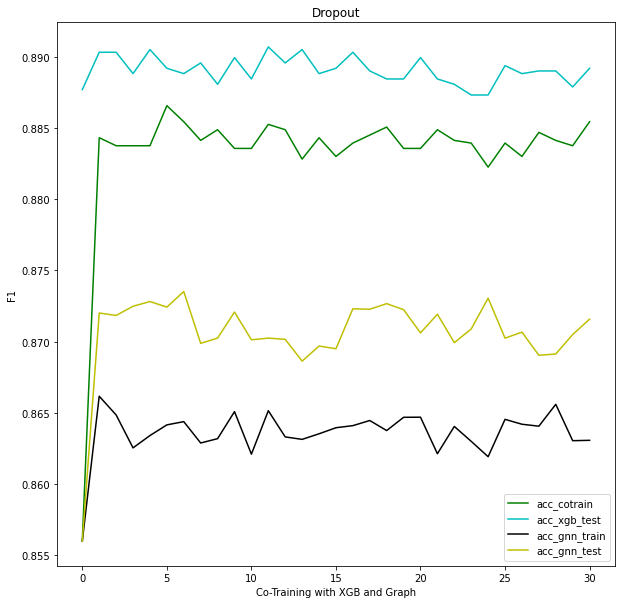

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches


indexing = range(len(f1_cotrain))
# hnd1, = plt.plot(indexing,f1_cotrain,'r',label='f1_cotrain')
hnd1, = plt.plot(indexing,acc_cotrain,'g',label='acc_cotrain')
# hnd2, = plt.plot(indexing,f1_xgb_test,'b',label='f1_xgb_test')
hnd2, = plt.plot(indexing,acc_xgb_test,'c',label='acc_xgb_test')
hnd2, = plt.plot(indexing,acc_gnn_train,'k',label='acc_gnn_train')
# hnd2, = plt.plot(indexing,f1_gnn_train,'m',label='f1_gnn_train')
hnd2, = plt.plot(indexing,acc_gnn_test,'y',label='acc_gnn_test')
# hnd2, = plt.plot(indexing,f1_gnn_test,'w',label='f1_gnn_test')
# print(num_n_new,num_p_new)

plt.legend(loc='best')
plt.ylabel('F1')
plt.xlabel('Co-Training with XGB and Graph')
plt.title('Dropout')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()